In [ ]:
# Simple language generator with RNN
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
# https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb
# Jan 2022

In [1]:
import torch
from torch import nn
import numpy as np

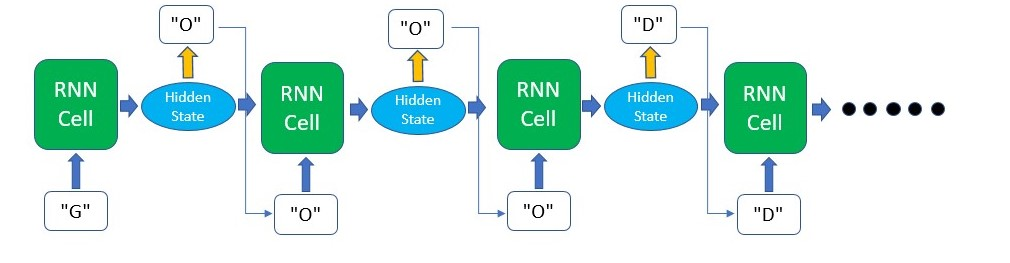

In [2]:
#text = ['hey how are you today','today i am fine really','have a nice day dude']
text = ['pagod na ako', 'nagugutom na ako', 'gusto kong matulog', 'anong pagkain ngayon']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [3]:
print(char2int)
maxlen = len(max(text, key=len))
print("The longest string has {} characters".format(maxlen))

{'a': 0, 'g': 1, ' ': 2, 'o': 3, 'd': 4, 'k': 5, 'y': 6, 'u': 7, 'p': 8, 't': 9, 'i': 10, 'l': 11, 'm': 12, 'n': 13, 's': 14}
The longest string has 20 characters


In [4]:
# Padding
# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i])<maxlen:
        text[i] += ' '

In [5]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])
    
    # Remove firsts character for target sequence
    target_seq.append(text[i][1:])
    print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: pagod na ako       
Target Sequence: agod na ako        
Input Sequence: nagugutom na ako   
Target Sequence: agugutom na ako    
Input Sequence: gusto kong matulog 
Target Sequence: usto kong matulog  
Input Sequence: anong pagkain ngayo
Target Sequence: nong pagkain ngayon


In [6]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [7]:
print(input_seq)
print(target_seq)

[[8, 0, 1, 3, 4, 2, 13, 0, 2, 0, 5, 3, 2, 2, 2, 2, 2, 2, 2], [13, 0, 1, 7, 1, 7, 9, 3, 12, 2, 13, 0, 2, 0, 5, 3, 2, 2, 2], [1, 7, 14, 9, 3, 2, 5, 3, 13, 1, 2, 12, 0, 9, 7, 11, 3, 1, 2], [0, 13, 3, 13, 1, 2, 8, 0, 1, 5, 0, 10, 13, 2, 13, 1, 0, 6, 3]]
[[0, 1, 3, 4, 2, 13, 0, 2, 0, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 7, 1, 7, 9, 3, 12, 2, 13, 0, 2, 0, 5, 3, 2, 2, 2, 2], [7, 14, 9, 3, 2, 5, 3, 13, 1, 2, 12, 0, 9, 7, 11, 3, 1, 2, 2], [13, 3, 13, 1, 2, 8, 0, 1, 5, 0, 10, 13, 2, 13, 1, 0, 6, 3, 13]]


In [8]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [9]:
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))

Input shape: (4, 19, 15) --> (Batch Size, Sequence Length, One-Hot Encoding Size)


In [10]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

In [11]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [12]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [13]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 5000
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# Training Run
input_seq = input_seq.to(device)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq = target_seq.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if (epoch%200 == 0):
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 200/5000............. Loss: 0.0521
Epoch: 400/5000............. Loss: 0.0115
Epoch: 600/5000............. Loss: 0.0054
Epoch: 800/5000............. Loss: 0.0032
Epoch: 1000/5000............. Loss: 0.0021
Epoch: 1200/5000............. Loss: 0.0015
Epoch: 1400/5000............. Loss: 0.0011
Epoch: 1600/5000............. Loss: 0.0008
Epoch: 1800/5000............. Loss: 0.0007
Epoch: 2000/5000............. Loss: 0.0005
Epoch: 2200/5000............. Loss: 0.0004
Epoch: 2400/5000............. Loss: 0.0144
Epoch: 2600/5000............. Loss: 0.0042
Epoch: 2800/5000............. Loss: 0.0025
Epoch: 3000/5000............. Loss: 0.0017
Epoch: 3200/5000............. Loss: 0.0013
Epoch: 3400/5000............. Loss: 0.0010
Epoch: 3600/5000............. Loss: 0.0008
Epoch: 3800/5000............. Loss: 0.0007
Epoch: 4000/5000............. Loss: 0.0006
Epoch: 4200/5000............. Loss: 0.0005
Epoch: 4400/5000............. Loss: 0.0004
Epoch: 4600/5000............. Loss: 0.0003
Epoch: 4800/500

In [15]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return (int2char[char_ind], hidden)

In [16]:
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [17]:
sample(model, 25, 'nagugutom')

'nagugutom na ako         '